In [2]:
from evaluation import get_trained_model
from rnamodif.architectures.rodan_event import RodanEvent
from rnamodif.data_utils.dataloading_events import MyIterableMixedDataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from rnamodif.evaluation.eval_vis_events import get_mismatches, plot_diversity, plot_cm, plot_alignments

import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

def eval_events(model_path, pos, neg, limit=10000, example_batch=0):
    #TODO i had vocab wrong -> 0134 -> effects?!
    model = get_trained_model(RodanEvent,model_path,{'vocab_map':{'A':0,'C':1,'G':2,'T':3}})
    dset = MyIterableMixedDataset(pos_readers=pos, neg_readers=neg, split='valid', window=4096, limit=limit)
    loader = DataLoader(dset, batch_size=64)#, num_workers=8)

    trainer = pl.Trainer(accelerator='gpu', profiler=None, precision=16)
    predictions = trainer.predict(model, loader, return_predictions=True)
    mismatches, diversity, cm, ex = get_mismatches(predictions, example_batch=example_batch)
    return mismatches, diversity, cm, ex
    
nih_10 = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_10'
nih_33 = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_33'
nih_5 = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_5'
nih_0 = '/home/jovyan/taiyaki_test/mapped_reads_2/m6A_0'
nov_pos = '/home/jovyan/taiyaki_test/mapped_reads_2/RNAAB090763_m6A'
nov_neg = '/home/jovyan/taiyaki_test/mapped_reads_2/RNAAB089716_m6A_UNM'

nih_1_model = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_0v33_event_modp_1/last.ckpt'
nih_1_narrow_model = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_0v33_event_modp_1_narrow/last.ckpt'
nih_05_model = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_0v33_event_modp_05/last.ckpt'

novoa_1_model = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_novoa_event_modp_1/last-v2.ckpt'
novoa_1_narrow_model = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_novoa_event_modp_1_narrow/last-v1.ckpt'
novoa_05_model = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_novoa_event_modp_05/last.ckpt'

nih_cectc = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_0v33_MIL_sampleavg_smooth5_blank03/last.ckpt'



dsets = {
    'nih_33':nih_33,
    'nih_10':nih_10,
    'nih_5':nih_5,
    'nih_neg':nih_0,
    # 'nov_pos':nov_pos,
    # 'nov_neg':nov_neg,
}
models = {
    'nih_cectc':nih_cectc,
    # 'nih_1_model':nih_1_model,
    # 'nih_1_narrow_model':nih_1_narrow_model,
    # 'nih_05_model':nih_05_model,
    # 'novoa_1_model':novoa_1_model,
    # 'novoa_1_narrow_model':novoa_1_narrow_model,
    # 'novoa_05_model':novoa_05_model,

}


In [3]:
from Bio import pairwise2

def cm_to_acc(cm):
    return (cm[0][0]+cm[1][1])/sum(cm.flatten())
    
    
def plot_alignments2(alignments):
    for lab in range(2):
        for pred in range(2):
            if(alignments[lab][pred]):
                print(f'label:{lab}, prediction:{pred}')
                # print(alignments[lab][pred])
                print(pairwise2.format_alignment(*alignments[lab][pred]))
            
def plot_results(mismatches, diversity, cm, example_alignments, title=''):
    print(title)
    plot_cm(cm)  
    
    for k,v in mismatches.items():
        print(k,v)
    print('acc', cm_to_acc(cm))
    # plot_diversity(diversity)  
    plot_alignments2(example_alignments)
    # plot_alignments(example_alignments)
    
    
    

# plot_results(*nih_z33)


In [4]:
import pickle
results = {}
for model_name, model in models.items():
    if('nih' in model_name):
        nih_train_perc = 0.8
        novoa_train_perc = 0.0
    elif('novoa' in model_name):
        nih_train_perc = 0.0
        novoa_train_perc = 0.8
        
    res_z33 = eval_events(model,[(nih_33,nih_train_perc)],[(nih_0,nih_train_perc)], limit=10000, example_batch=30)
    res_z10 = eval_events(model,[(nih_10,0.0)],[(nih_0,nih_train_perc)])
    res_z5 = eval_events(model,[(nih_5,0.0)],[(nih_0,nih_train_perc)])
    # res_nov = eval_events(model,[(nov_pos,novoa_train_perc)],[(nov_neg,novoa_train_perc)])
    results[model_name] = {'z33':res_z33,'z10':res_z10, 'z5':res_z5}#,'nov':res_nov}
    # results[model_name] = {'z33':res_z33}
    

with open('events_eval.pickle', 'wb') as f:
    pickle.dump(results, f)

using CTC loss
using CTC loss


Using 16bit native Automatic Mixed Precision (AMP)
/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:93: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return bound(*args, **kwds)
100%|██████████| 157/157 [00:10<00:00, 15.23it/s]


using CTC loss
using CTC loss


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

100%|██████████| 157/157 [00:10<00:00, 15.22it/s]


using CTC loss
using CTC loss


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

100%|██████████| 157/157 [00:10<00:00, 14.80it/s]


In [15]:
results.keys()

dict_keys([])

In [6]:
results['nih_cectc'].keys()

dict_keys(['z33'])

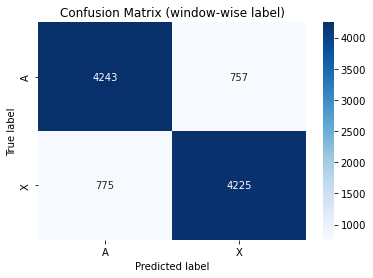

A => A 131715
X => A 119699
X => X 7569
- => X 6123
- => A 3251
X => - 3112
G => - 1390
- => C 1313
- => T 1206
A => - 1152
C => - 1138
- => G 1076
T => - 1017
A => X 506
T => X 447
C => X 417
G => X 411
C => A 188
X => T 134
G => A 122
X => G 117
T => A 115
X => C 98
T => G 43
C => T 35
G => C 20
C => G 19
G => T 19
A => G 19
T => C 12
A => T 12
A => C 7
acc 0.8468
label:0, prediction:0
ACTAACCCCGGAGAGAAAGGTTTTGTGACGACGTGACCCGTGACGAACAAACCTCAGGAGAAAACCGCTCCGAACAAATTTTAAAAGACGGACTGAAGAAACCGTGAAACGAAGCAATGAACGAACCCGAC
 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
-CTAACCCCGGAGAGAAAGGTTTTGTGACGACGTGACCCGTGACGAACAAACCTCAGGAGAAAACCGCTCCGAACAAATTTTAAAAGACGGACTGAAGAAACCGTGAAACGAAGCAATGAACGAACCCGAC
  Score=255

label:0, prediction:1
-ATCCGTAAGTTTAAGAGTAAGTTGTGAAAGTACTATCAGAGTTTTGGTCCATCTCATGATAGTTTAGATTGACGTGGACTT-
 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 
XATCCGTAAG

In [5]:
plot_results(*results['nih_cectc']['z33'])
# plot_results(*results['nih_cectc']['z10'])

# plot_results(*results['nih_cectc']['z5'])
# plot_results(*results['nih_cectc']['nov'])
# plot_results(*results['novoa_1_model']['nov'])
# plot_results(*results['novoa_1_model']['z33'])


In [6]:
model = get_trained_model(RodanEvent,nih_cectc,{'vocab_map':{'A':0,'C':1,'G':2,'T':3}})
pos, neg = [(nih_33,nih_train_perc)],[(nih_0,nih_train_perc)]
dset = MyIterableMixedDataset(pos_readers=pos, neg_readers=neg, split='valid', window=4096, limit=1000)
loader = DataLoader(dset, batch_size=64)#, num_workers=8)
trainer = pl.Trainer(accelerator='gpu', profiler=None, precision=16)
predictions = trainer.predict(model, loader, return_predictions=True)

using CTC loss
using CTC loss


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

tensor(0.0402)
variance tensor(0.0250)
tensor(0.1000)
variance tensor(0.0020)
tensor(0.0573)
tensor(0.0158)


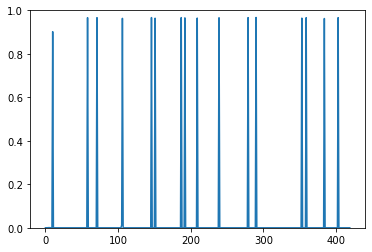

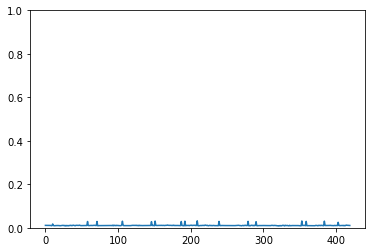

ACTGGCGCTTGGTCTAGCCGATCGTCCACGTCTGGAAGGTCTCGGAAGTTGTATTTTCGGGACTCCGTTATGGCACGGCCCGCGTTTGGATCATCCTTATCGGAGT


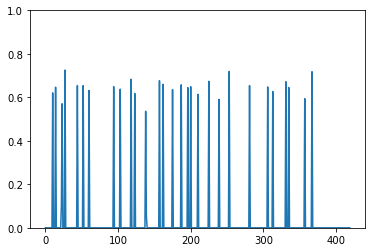

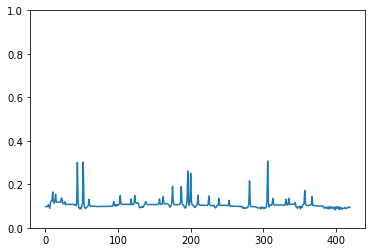

TXXXXGXCGGXCTGXXGXXXCCGTGXXXCGXXGCXXTGXXCGXXCCCGXCCGGCCGTXGXXXTGGCTCGXXTCGGTTTTGTTCTCGT


In [7]:
import torch
import numpy as np
from matplotlib import pyplot as plt
for x,y in predictions[3:]:
    x = torch.softmax(x.float(), dim=-1)
    pos_i = np.array([1 if 'X' in lab else 0 for lab in y], dtype=bool)
    neg_i = np.array(1-pos_i, dtype=bool)
    print(x[:,pos_i,1].mean())
    print('variance', x[:,pos_i,1].var())
    
    print(x[:,pos_i,5].mean())
    print('variance', x[:,pos_i,5].var())
    
    print(x[:,neg_i,1].mean())
    print(x[:,neg_i,5].mean())
    
    for i in range(x.size()[1])[1:3]:
        sub_x = x[:,i,:]
        plt.plot(sub_x[:,1])
        plt.ylim(0,1)
        plt.show()
        plt.plot(sub_x[:,5])
        plt.ylim(0,1)
        plt.show()
        
        print(y[i])
    break
